# Importing the libraries

In [1]:
import numpy as np # Numerical computing
import pandas as pd # Data manipulation and analysis
import os # Interacting with the operating system
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Statistical data visualization

# Warnings module for handling warnings in Python
import warnings
# tqdm for adding progress bars to loops, with notebook module for Jupyter notebooks
from tqdm.notebook import tqdm
# Suppressing warnings to keep the output clean
warnings.filterwarnings('ignore')
# Jupyter magic command for inline plotting with Matplotlib
%matplotlib inline

In [2]:
import tensorflow as tf
# Importing load_img from Keras for loading images
from keras.preprocessing.image import load_img
# Importing Sequential, Model, and various layers from Keras for building neural networks
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

# Loading the dataset

In [3]:
# Define the base directory containing the images
BASE_DIR = './UTKFace/'

In [4]:
# Initialize lists to store image paths, age labels, and gender labels
image_paths = []
age_labels = []
gender_labels = []

# Iterate through the files in the base directory
for filename in tqdm(os.listdir(BASE_DIR)):
    if '_' not in filename:
        print(f"Skipping file '{filename}' - does not follow the expected naming convention.")
        continue

    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')

    try:
        age = int(temp[0])
        gender = int(temp[1])
    except ValueError:
        print(f"Skipping file '{filename}' - age or gender is not a valid integer.")
        continue

    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23710 [00:00<?, ?it/s]

Skipping file 'Untitled.ipynb' - does not follow the expected naming convention.
Skipping file '.ipynb_checkpoints' - age or gender is not a valid integer.


In [5]:
# Convert into DataFrame
df = pd.DataFrame()
df['image'] = image_paths
df['age'] = age_labels
df['gender']  = gender_labels

In [6]:
df.head()

,image,age,gender
0,./UTKFace/9_1_2_20161219204347420.jpg.chip.jpg,9,1
1,./UTKFace/36_0_1_20170117163203851.jpg.chip.jpg,36,0
2,./UTKFace/86_1_0_20170120225751953.jpg.chip.jpg,86,1
3,./UTKFace/26_1_0_20170116171048641.jpg.chip.jpg,26,1
4,./UTKFace/1_1_2_20161219154612988.jpg.chip.jpg,1,1


In [7]:
# Map labels for Gender
gender_dict = {0 : 'Male', 1 : 'Female'}

# Exploratory Data Analysis

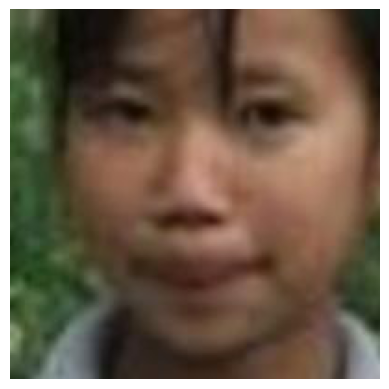

In [8]:
# Open the image using PIL
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

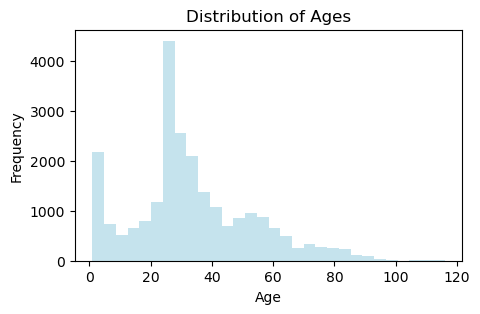

In [9]:
# Convert the 'age' column to a NumPy array and flatten it
ages_array = df['age'].values.flatten()

plt.figure(figsize=(5, 3))

# Plot the histogram of ages using matplotlib
plt.hist(ages_array, bins=30, color='lightblue', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Ages')
plt.show()

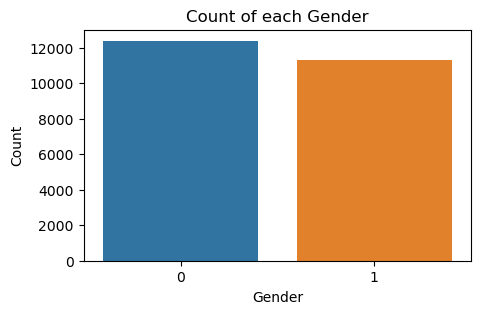

In [10]:
# Check the counts of each unique value in the 'gender' column
gender_counts = df['gender'].value_counts()

plt.figure(figsize=(5, 3))

# Create a bar plot using seaborn
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of each Gender')
plt.show()

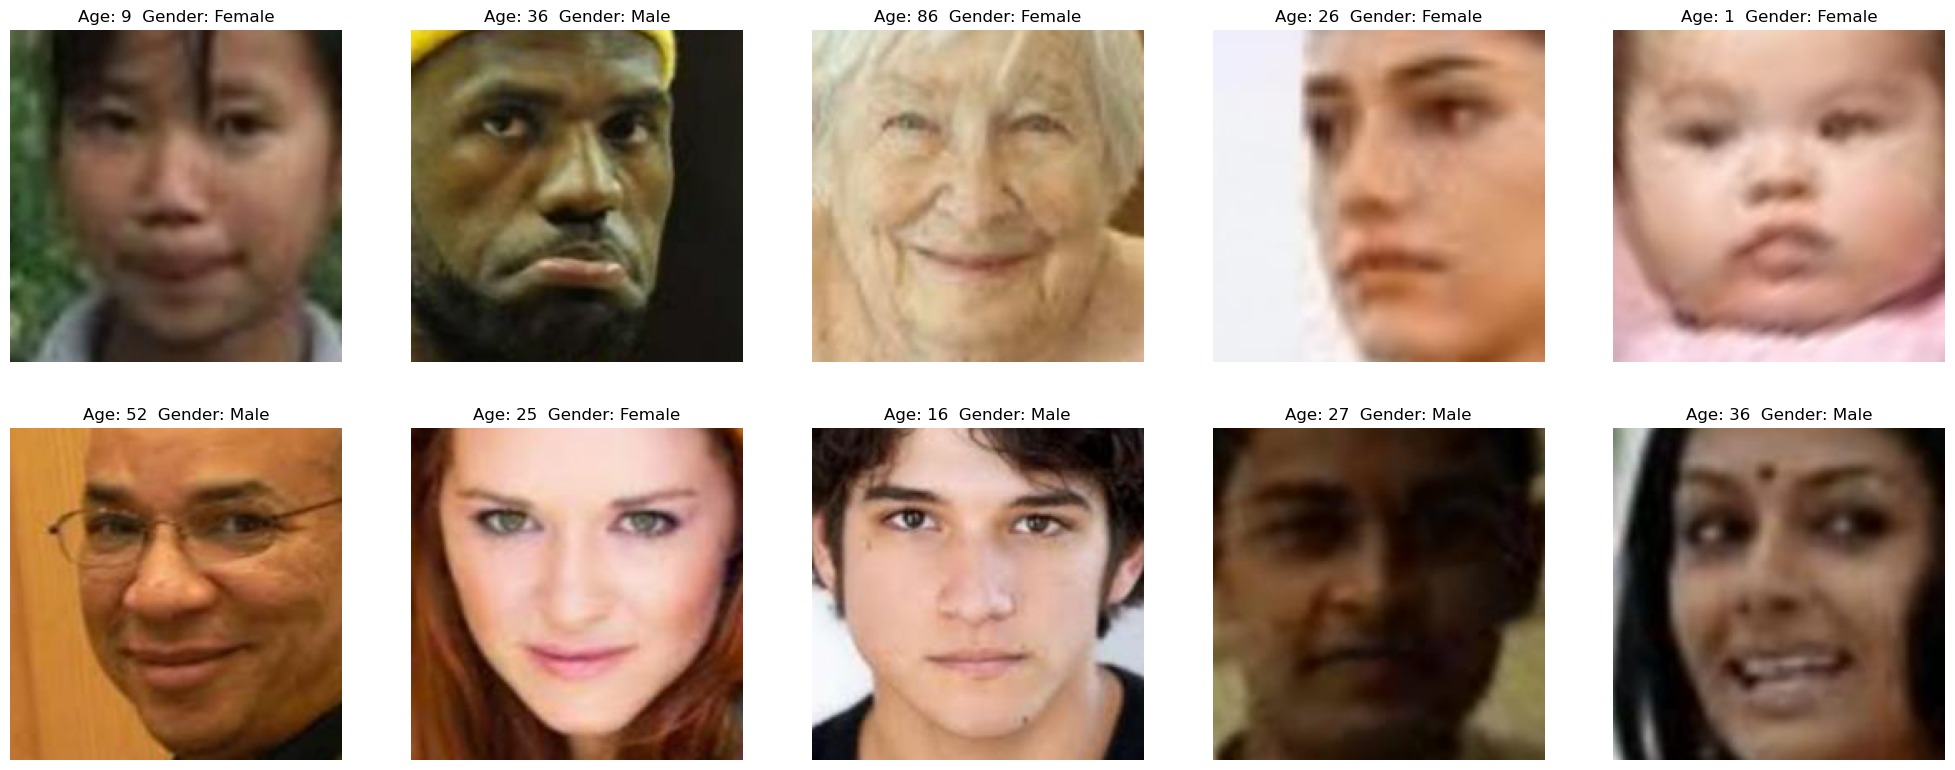

In [11]:
# Display a grid of images
plt.figure(figsize=(25, 25))

# Select the first 10 rows from the DataFrame
files = df.iloc[0:10]

# Iterate through the selected rows
for index, file, age, gender in files.itertuples():
    # Create a subplot in a 5x5 grid
    plt.subplot(5, 5, index + 1)
    # Load the image using the file path
    img = load_img(file)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    # Display the image
    plt.imshow(img)
    # Set the title with age and gender information
    plt.title(f"Age: {age}  Gender: {gender_dict[gender]}")
    # Turn off axis labels for cleaner visualization
    plt.axis('off')

plt.show()

# Feature Extraction


In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        # Load the image in grayscale
        img = load_img(image, grayscale=True)
        # Resize the image to 128x128 pixels using anti-aliasing
        img = img.resize((128, 128), Image.ANTIALIAS)
        # Convert the image to a NumPy array
        img = np.array(img)
        features.append(img)
    
    # Convert the features list to a NumPy array
    features = np.array(features)
    # Reshape the array to have dimensions (number of images, 128, 128, 1)
    features = features.reshape(len(features), 128, 128, 1)
    
    return features

In [13]:
x = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
x.shape

(23708, 128, 128, 1)

In [15]:
# Normalisation
x = x/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128,128,1)

# Model Creation

In [18]:
# Define the input layer with the specified input shape
inputs = Input((input_shape))

# Convolutional layers with max pooling
conv_1 = Conv2D(32, kernel_size = (3,3), activation = 'relu')(inputs)
maxp_1 = MaxPooling2D(pool_size = (2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size = (3,3), activation = 'relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size = (2,2))(conv_1)
conv_3 = Conv2D(128, kernel_size = (3,3), activation = 'relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size = (2,2))(conv_1)
conv_4 = Conv2D(256, kernel_size = (3,3), activation = 'relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size = (2,2))(conv_1)

# Flatten and dense layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation = 'relu')(flatten)
dense_2 = Dense(256, activation = 'relu')(flatten)

# Dropout layers with a dropout rate of 0.3 for regularization
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# Output layers for gender and age
output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out')(dropout_1)
output_2 = Dense(1, activation = 'relu', name = 'age_out')(dropout_2)

# Compile the model with Adam optimizer and appropriate losses
model = Model(inputs = [inputs], outputs = [output_1, output_2])
model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy'])

2024-01-06 23:54:12.469750: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-06 23:54:12.470824: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-06 23:54:12.471845: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-06 23:54:12.472838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-06 23:54:12.473839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 g2D)                                                                                             
                                                                                                  
 flatten (Flatten)           (None, 127008)               0         ['max_pooling2d_3[0][0]'] 

# Model Training

In [20]:
# Train the model on input data 'x' with corresponding labels for gender and age
# Using batch size of 64 for 10 epochs with 20% validation split
history = model.fit(x=x, y=[y_gender, y_age], batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10


2024-01-06 23:54:47.213472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


297/297 [==============================] - 78s 253ms/step - loss: 18.5826 - gender_out_loss: 2.4201 - age_out_loss: 16.1626 - gender_out_accuracy: 0.6266 - age_out_accuracy: 0.0465 - val_loss: 12.9579 - val_gender_out_loss: 0.4836 - val_age_out_loss: 12.4743 - val_gender_out_accuracy: 0.8062 - val_age_out_accuracy: 0.0493
Epoch 2/10
297/297 [==============================] - 72s 244ms/step - loss: 12.5210 - gender_out_loss: 0.5090 - age_out_loss: 12.0120 - gender_out_accuracy: 0.8001 - age_out_accuracy: 0.0417 - val_loss: 11.5143 - val_gender_out_loss: 0.3687 - val_age_out_loss: 11.1456 - val_gender_out_accuracy: 0.8425 - val_age_out_accuracy: 0.0367
Epoch 3/10
297/297 [==============================] - 72s 241ms/step - loss: 11.5055 - gender_out_loss: 0.3992 - age_out_loss: 11.1063 - gender_out_accuracy: 0.8292 - age_out_accuracy: 0.0345 - val_loss: 12.9949 - val_gender_out_loss: 0.3479 - val_age_out_loss: 12.6470 - val_gender_out_accuracy: 0.8505 - val_age_out_accuracy: 0.0179
Epoch 

# Ploting the results

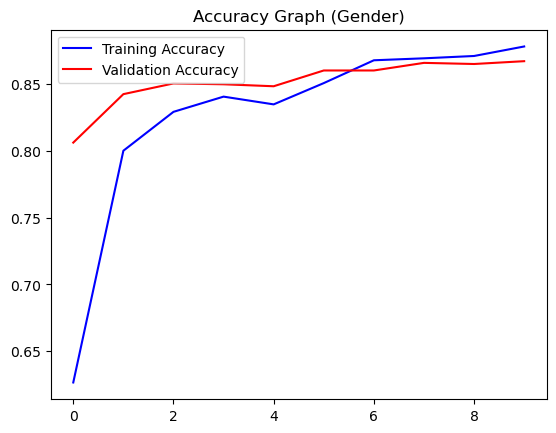

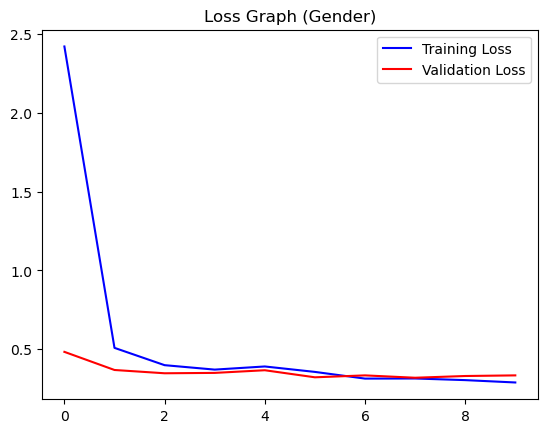

In [21]:
# Plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph (Gender)')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph (Gender)')
plt.legend()
plt.show()

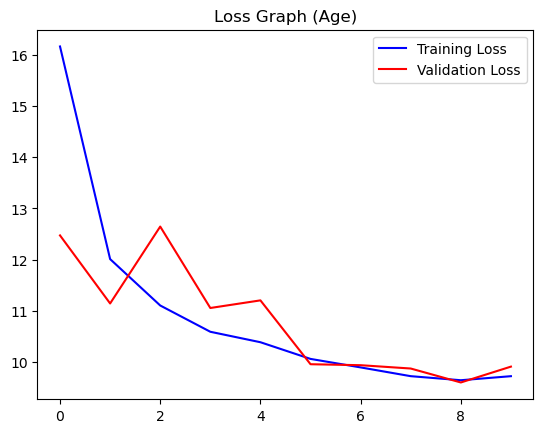

In [22]:
# Plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph (Age)')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Female Original Age: 32
1/1 [==============================] - 0s 281ms/step
Predicted Gender: Female Predicted Age: 35


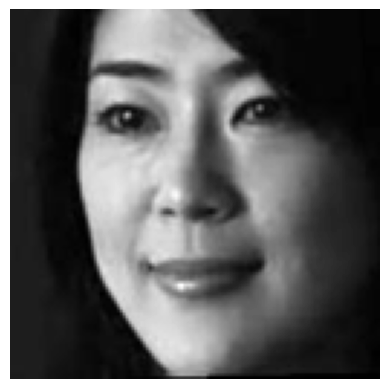

In [23]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# Predict from model
pred = model.predict(x[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(x[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 65
1/1 [==============================] - 0s 42ms/step
Predicted Gender: Male Predicted Age: 60


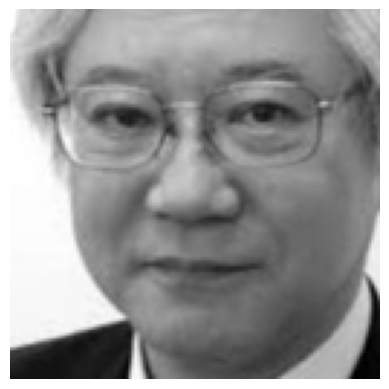

In [45]:
image_index = 301
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# Predict from model
pred = model.predict(x[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(x[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 32
1/1 [==============================] - 0s 16ms/step
Predicted Gender: Male Predicted Age: 35


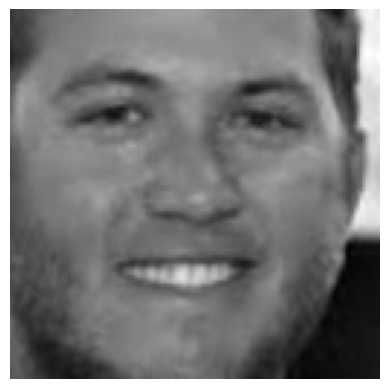

In [46]:
image_index = 11932
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# Predict from model
pred = model.predict(x[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(x[image_index].reshape(128, 128), cmap='gray');